In [29]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install scikit-learn
# %pip install tensorflow
# %pip install -U imbalanced-learn

In [30]:
import numpy as np
import pandas as pd

In [31]:
COMMODITY = 'copper'

DATE_COLUMN = 'Date'
VALUE_COLUMN = 'Value'  
QUANTITY_COLUMN = 'Std. Quantity (POUND)'
UNIT_RATE_COLUMN = 'Std. Unit Rate ($/POUND)'
BRENT_OIL_COLUMN = 'Brent Oil Value'
WTI_OIL_COLUMN = 'WTI Oil Value'

VALUE_SPIKES_COLUMN = 'Value Spikes'  
QUANTITY_SPIKES_COLUMN = 'Std. Quantity (POUND) Spikes'
UNIT_RATE_SPIKES_COLUMN = 'Std. Unit Rate ($/POUND) Spikes'
BRENT_OIL_SPIKES_COLUMN = 'Brent Oil Value Spikes'
WTI_OIL_SPIKES_COLUMN = 'WTI Oil Value Spikes'
SHIP_COUNT_SPIKES_COLUMN = 'Ship Count Spikes'
PORT_COUNT_SPIKES_COLUMN = 'Port Count Spikes'

FEATURE_COLUMNS = [VALUE_COLUMN, QUANTITY_COLUMN, UNIT_RATE_COLUMN,  'Price', WTI_OIL_COLUMN, BRENT_OIL_COLUMN]
# FEATURE_COLUMNS = [VALUE_SPIKES_COLUMN, QUANTITY_SPIKES_COLUMN, UNIT_RATE_SPIKES_COLUMN,  WTI_OIL_SPIKES_COLUMN, BRENT_OIL_SPIKES_COLUMN]

SHIP_COUNT_COLUMN = 'ship_count'
PORT_COUNT_COLUMN = 'popular_port_count'

ORIGIN_COUNTRY_COLUMN = 'Country of Origin'
DEST_COUNTRY_COLUMN = 'Country of Destination'

PETROL_FILE_PATH = '../volza/petroleum/petrol_crude_oil_spot_price.csv'
VOLZA_FILE_PATH = f'../volza/{COMMODITY}/{COMMODITY}.csv'
PRICE_FILE_PATH = f"../volza/{COMMODITY}/{COMMODITY}_prices.csv"
AIS_POPULAR_FILE_PATH = f'../ais/ais_ml_features.csv' 

NB_OUTPUT_PATH = f"model_performance/{COMMODITY}/{COMMODITY}_model_performance (No Balancing).csv"
RUS_OUTPUT_PATH = f"model_performance/{COMMODITY}/{COMMODITY}_model_performance (Random Under Sampling).csv"
ROS_OUTPUT_PATH = f"model_performance/{COMMODITY}/{COMMODITY}_model_performance (Random Over Sampling).csv"


SPIKES_THRESHOLD = 2
SPIKES_WINDOW_SIZE = 20
BIN_COUNT = 10
FILL_METHOD = 'ffill'

RANDOM_STATE = 42

In [32]:
# Only keep rows where we have usable quantity units (kg, ton) and standardizing it. For VOLZA only.
def convert_to_pound(df, quantity_col='Std. Quantity', unit_col='Std. Unit'):
    converstion_factors = {
        'TON': 907.185 * 2.20462,  
        'TNE': 1000 * 2.20462,     
        'KGS': 2.20462,            
        'Kgs': 2.20462,
    }

    df_filtered = df[df[unit_col].isin(converstion_factors.keys())]

    def convert(row):
        unit = row[unit_col]
        quantity = row[quantity_col]
        return quantity * converstion_factors.get(unit,1)
    
    df_filtered = df_filtered[df_filtered[VALUE_COLUMN] != 0]
    df_filtered[QUANTITY_COLUMN] = df_filtered.apply(convert, axis=1)
    df_filtered = df_filtered[df_filtered[QUANTITY_COLUMN] != 0]

    df_filtered[UNIT_RATE_COLUMN] = df_filtered[VALUE_COLUMN] / df_filtered[QUANTITY_COLUMN]

    return df_filtered

## Spike detection

In [33]:
from datetime import datetime

#Formatting the date and price for Volza data
volza_pd = pd.read_csv(VOLZA_FILE_PATH)
volza_pd = volza_pd[(volza_pd["Country of Origin"].notnull()) & (volza_pd["Country of Destination"].notnull())]
volza_pd = volza_pd.rename(columns={'Unnamed: 0': 'ID'})
volza_pd['Date'] = volza_pd['Date'].apply(lambda x: x.split(' ')[0])
volza_pd['Date'] = pd.to_datetime(volza_pd['Date'], errors='raise', format='%Y-%m-%d')
volza_pd = convert_to_pound(volza_pd)
volza_pd.head(3)

,0,Date,HS Code,Product Description,Consignee,Notify Party Name,Shipper,Std. Quantity,Std. Unit,Standard Unit Rate INR,...,Freight Term,Marks Number,HS Product Description,Gross Weight,Consignee Address,Shipper Address,Notify Party Address,Country Name,Std. Quantity (POUND),Std. Unit Rate ($/POUND)
0,1,2019-04-01,74020000,"COPPER, UNREFINED; COPPER ANODES FOR ELECTROLY...",NaN,NaN,NaN,0.007,TON,-,...,-,-,NaN,0.0,NaN,NaN,NaN,Lithuania T1 Import,13.999987,5.537862
1,2,2019-04-01,74020000,"COPPER, UNREFINED; COPPER ANODES FOR ELECTROLY...",NaN,NaN,NaN,0.021,TON,-,...,-,-,NaN,0.0,NaN,NaN,NaN,Portugal T1 Import,41.999962,65.516488
2,3,2019-04-01,74020000,"COPPER, UNREFINED; COPPER ANODES FOR ELECTROLY...",NaN,NaN,NaN,0.001,TON,-,...,-,-,NaN,0.0,NaN,NaN,NaN,France T1 Import,1.999998,10.110009


In [34]:
#Preprocessing the AIS data
ais_popular_pd = pd.read_csv(AIS_POPULAR_FILE_PATH)
# volza_pd['Date'] = volza_pd['Date'].apply(lambda x: x.split(' ')[0])
ais_popular_pd['Date'] = pd.to_datetime(ais_popular_pd['Date'])
ais_popular_pd.head(3)


,Date,ship_count,popular_port,popular_port_count
0,2020-11-10,8,LTKLJ,18
1,2020-11-12,20,IDSKP,8
2,2020-11-29,9,CNSHA,2


In [35]:
#Preprocessing the price data
prices_pd = pd.read_csv(PRICE_FILE_PATH)
prices_pd['Date'] = prices_pd['Date'].apply(lambda x: datetime.strptime(x, "%b %d, %Y").strftime("%Y-%m-%d"))
prices_pd['Date'] = pd.to_datetime(prices_pd['Date'], errors='raise', format='%Y-%m-%d')
prices_pd['Price'] = prices_pd['Price'].astype(float)  
prices_pd = prices_pd[['Date', 'Price']]
prices_pd

,Date,Price
0,2022-12-30,3.8055
1,2022-12-29,3.8210
2,2022-12-28,3.8320
3,2022-12-27,3.8335
4,2022-12-23,3.8030
...,...,...
1003,2019-01-08,2.6605
1004,2019-01-07,2.6410
1005,2019-01-04,2.6515
1006,2019-01-03,2.5705


In [36]:
#Aggregate volza data by day
date_wise_volza = volza_pd.groupby("Date")[[VALUE_COLUMN,QUANTITY_COLUMN,'Gross Weight']].sum()

In [37]:
# Avg of Commodity Price in Volza
avg_price_volza = volza_pd.groupby('Date')[UNIT_RATE_COLUMN].mean()
date_wise_volza = date_wise_volza.join(avg_price_volza, how='left')
date_wise_volza

,Value,Std. Quantity (POUND),Gross Weight,Std. Unit Rate ($/POUND)
Date,,,,
2019-01-01,3.580679e+08,1.115013e+08,512426.9,23.234310
2019-01-02,2.899774e+07,9.930702e+06,4507752.0,2.912255
2019-01-03,1.652543e+07,5.351697e+06,2428782.0,4.118381
2019-01-04,1.381037e+05,4.362061e+04,0.0,2.563629
2019-01-06,1.854971e+07,6.670174e+06,0.0,1790.400393
...,...,...,...,...
2022-12-28,3.660210e+07,1.011938e+07,2301364.0,3.447410
2022-12-29,9.597299e+06,5.367289e+06,2415.6,6.130818
2022-12-30,1.148950e+08,5.010989e+06,360.0,168.297919


In [38]:
# Petroleum data prep
petrol_df = pd.read_csv(PETROL_FILE_PATH, delimiter=';', on_bad_lines='warn')
petrol_df['Date'] = pd.to_datetime(petrol_df['Date'])

# Split based on types of oil
brent_df = petrol_df[petrol_df['product-name']=='UK Brent Crude Oil']
wti_df = petrol_df[petrol_df['product-name']=='WTI Crude Oil']

brent_df.rename(columns={'Value':'Brent Oil Value'}, inplace=True)
wti_df.rename(columns={'Value':'WTI Oil Value'}, inplace=True)


C:\Users\manim\AppData\Local\Temp\ipykernel_19996\273638861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brent_df.rename(columns={'Value':'Brent Oil Value'}, inplace=True)
C:\Users\manim\AppData\Local\Temp\ipykernel_19996\273638861.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_df.rename(columns={'Value':'WTI Oil Value'}, inplace=True)


In [39]:
# Combining dataframes
prices_pd = prices_pd.set_index('Date')
ais_popular_pd = ais_popular_pd.set_index('Date')
date_wise_volza = date_wise_volza.join(ais_popular_pd, how="left").fillna(method=FILL_METHOD)
aggregated_df = date_wise_volza.join(prices_pd, how="left").fillna(method=FILL_METHOD)
# date_wise_volza = date_wise_volza.join(ais_popular_pd, how="left").fillna(method='ffill')
aggregated_df = aggregated_df.merge(brent_df[[DATE_COLUMN, BRENT_OIL_COLUMN]], on='Date', how='left').fillna(method=FILL_METHOD)
aggregated_df = aggregated_df.merge(wti_df[[DATE_COLUMN, WTI_OIL_COLUMN]], on='Date', how='left').fillna(method=FILL_METHOD)
aggregated_df

C:\Users\manim\AppData\Local\Temp\ipykernel_19996\261862122.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  date_wise_volza = date_wise_volza.join(ais_popular_pd, how="left").fillna(method=FILL_METHOD)
C:\Users\manim\AppData\Local\Temp\ipykernel_19996\261862122.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggregated_df = date_wise_volza.join(prices_pd, how="left").fillna(method=FILL_METHOD)
C:\Users\manim\AppData\Local\Temp\ipykernel_19996\261862122.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggregated_df = aggregated_df.merge(brent_df[[DATE_COLUMN, BRENT_OIL_COLUMN]], on='Date', how='left').fillna(method=FILL_METHOD)
C:\Users\manim\AppData\Local\Temp\ipykernel_19996\261862122.py:8: FutureWarnin

,Date,Value,Std. Quantity (POUND),Gross Weight,Std. Unit Rate ($/POUND),ship_count,popular_port,popular_port_count,Price,Brent Oil Value,WTI Oil Value
0,2019-01-01,3.580679e+08,1.115013e+08,512426.9,23.234310,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-02,2.899774e+07,9.930702e+06,4507752.0,2.912255,NaN,NaN,NaN,2.6250,54.06,46.31
2,2019-01-03,1.652543e+07,5.351697e+06,2428782.0,4.118381,NaN,NaN,NaN,2.5705,53.23,46.92
3,2019-01-04,1.381037e+05,4.362061e+04,0.0,2.563629,NaN,NaN,NaN,2.6515,55.64,47.76
4,2019-01-06,1.854971e+07,6.670174e+06,0.0,1790.400393,NaN,NaN,NaN,2.6515,55.64,47.76
...,...,...,...,...,...,...,...,...,...,...,...
1233,2022-12-28,3.660210e+07,1.011938e+07,2301364.0,3.447410,26021.0,SGSIN,9233.0,3.8320,81.70,78.89
1234,2022-12-29,9.597299e+06,5.367289e+06,2415.6,6.130818,24039.0,SGSIN,8861.0,3.8210,80.96,78.43
1235,2022-12-30,1.148950e+08,5.010989e+06,360.0,168.297919,19952.0,SGSIN,8118.0,3.8055,82.82,80.16
1236,2022-12-31,1.290664e+07,3.340804e+06,0.0,3.758166,8925.0,USMSY,2673.0,3.8055,82.82,80.16


### Time series decomposition

In [40]:
FEATURE_COLUMNS = [VALUE_COLUMN, QUANTITY_COLUMN, UNIT_RATE_COLUMN, WTI_OIL_COLUMN, BRENT_OIL_COLUMN, 'Price', SHIP_COUNT_COLUMN, PORT_COUNT_COLUMN]

In [41]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt  
import pandas as pd
# Perform decomposition for each column

df = aggregated_df.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df = df.asfreq('D') 
df.fillna(method='ffill', inplace=True)

C:\Users\manim\AppData\Local\Temp\ipykernel_19996\3514716655.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


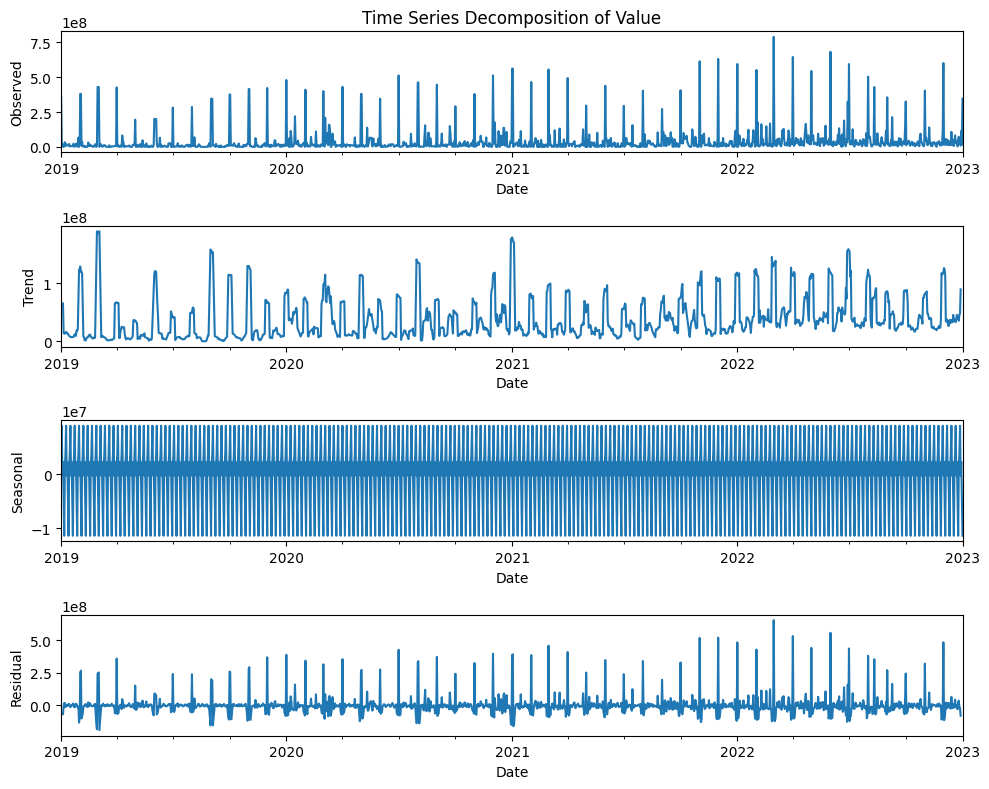

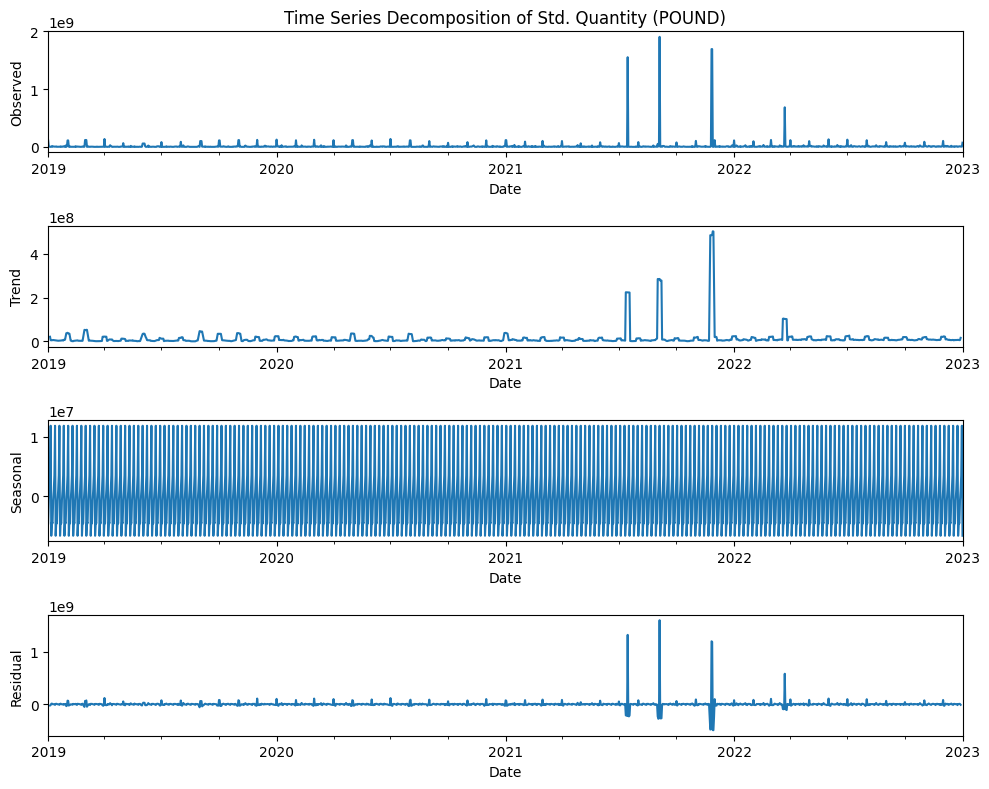

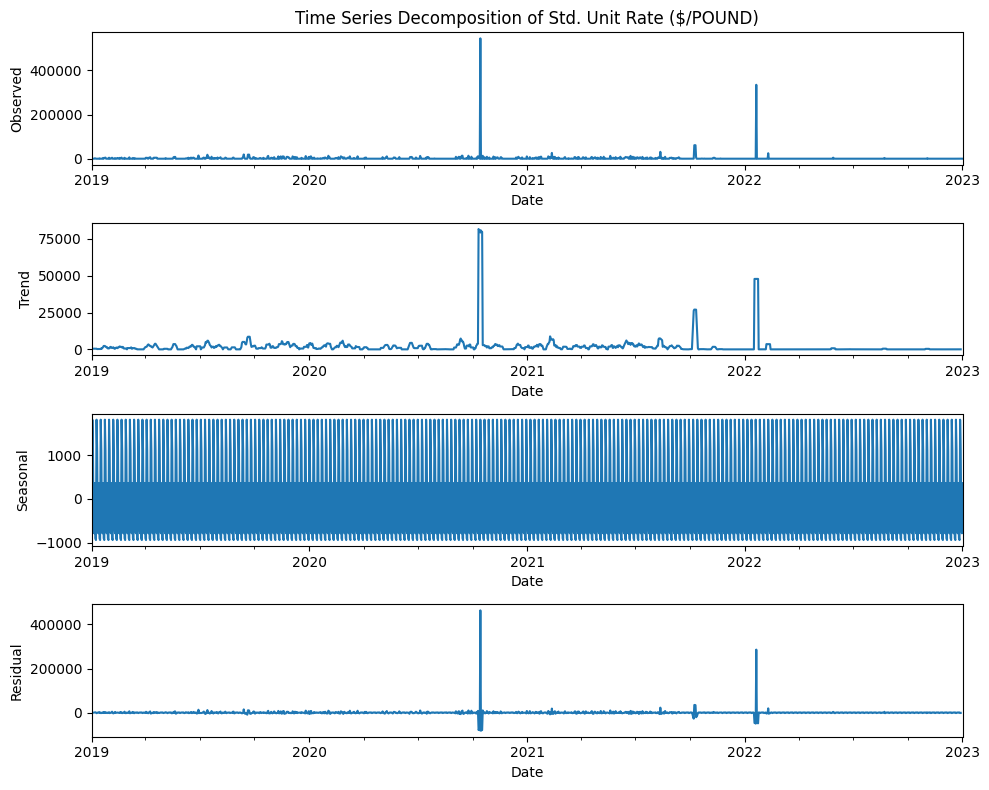

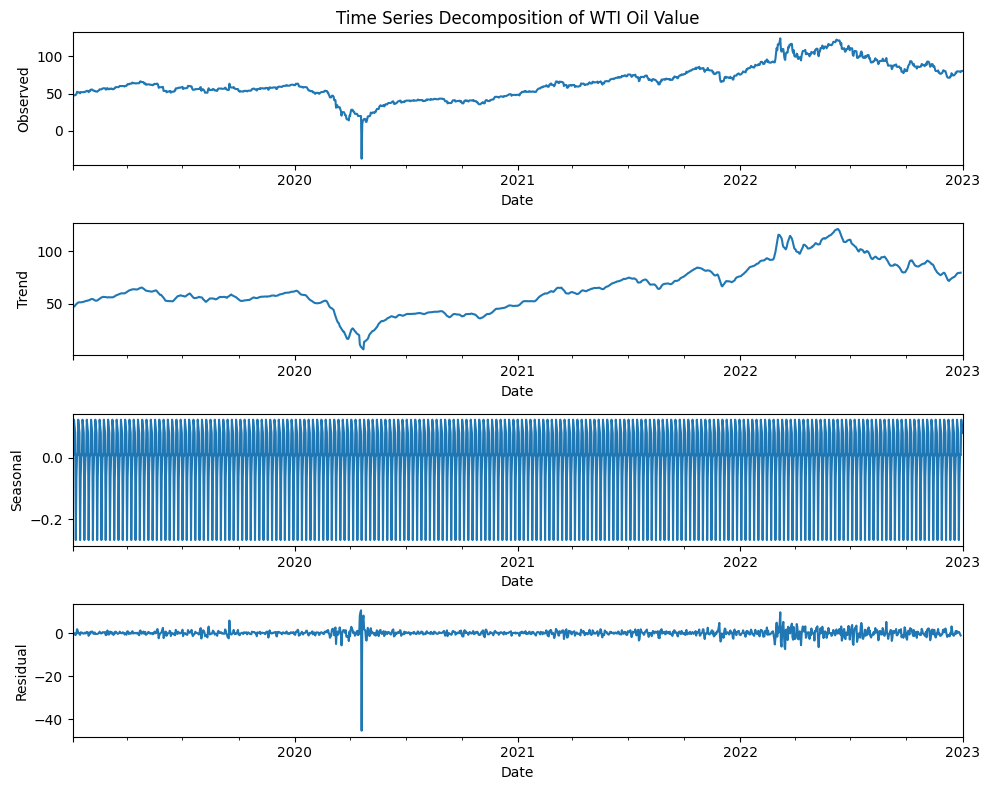

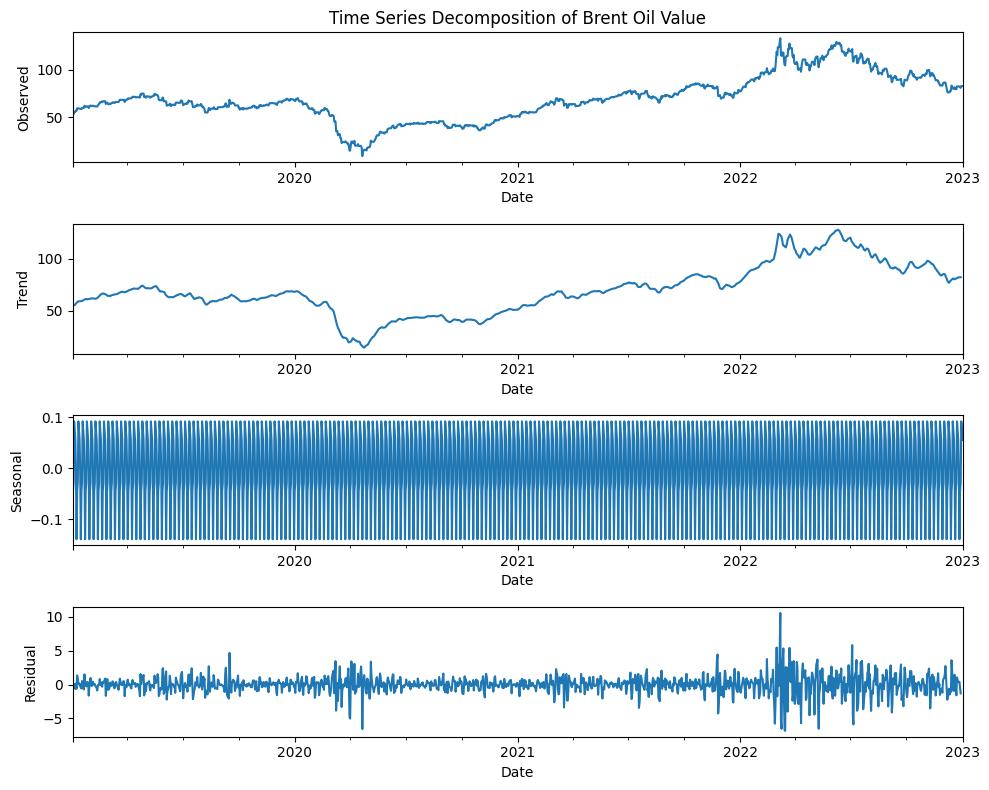

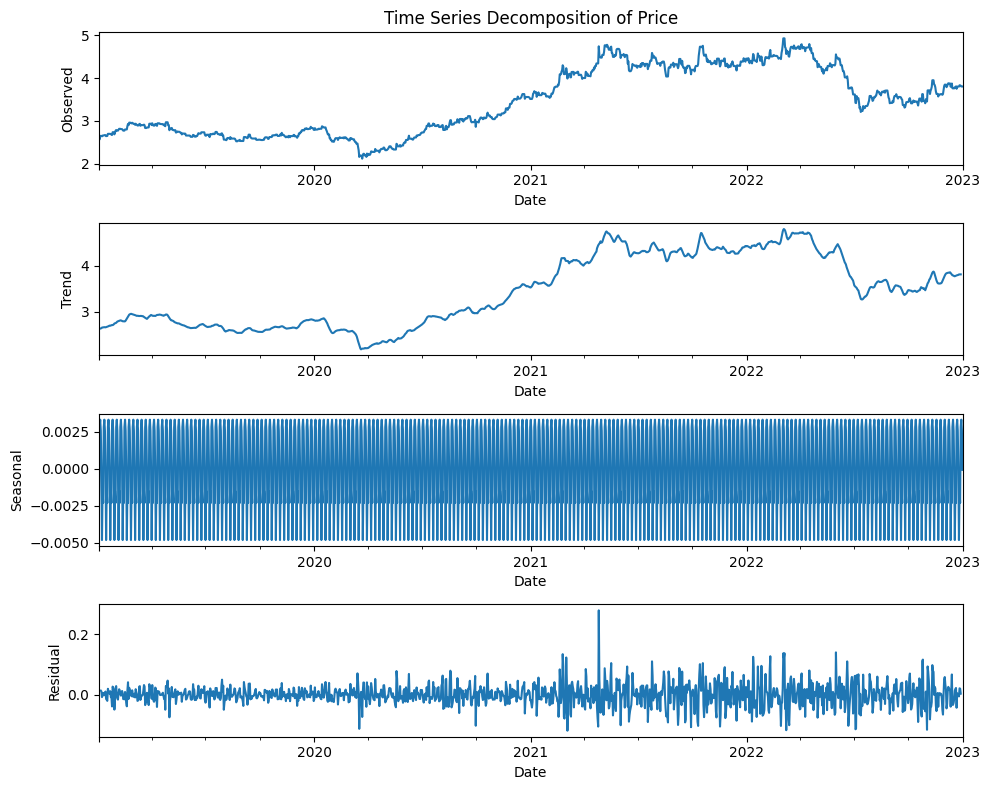

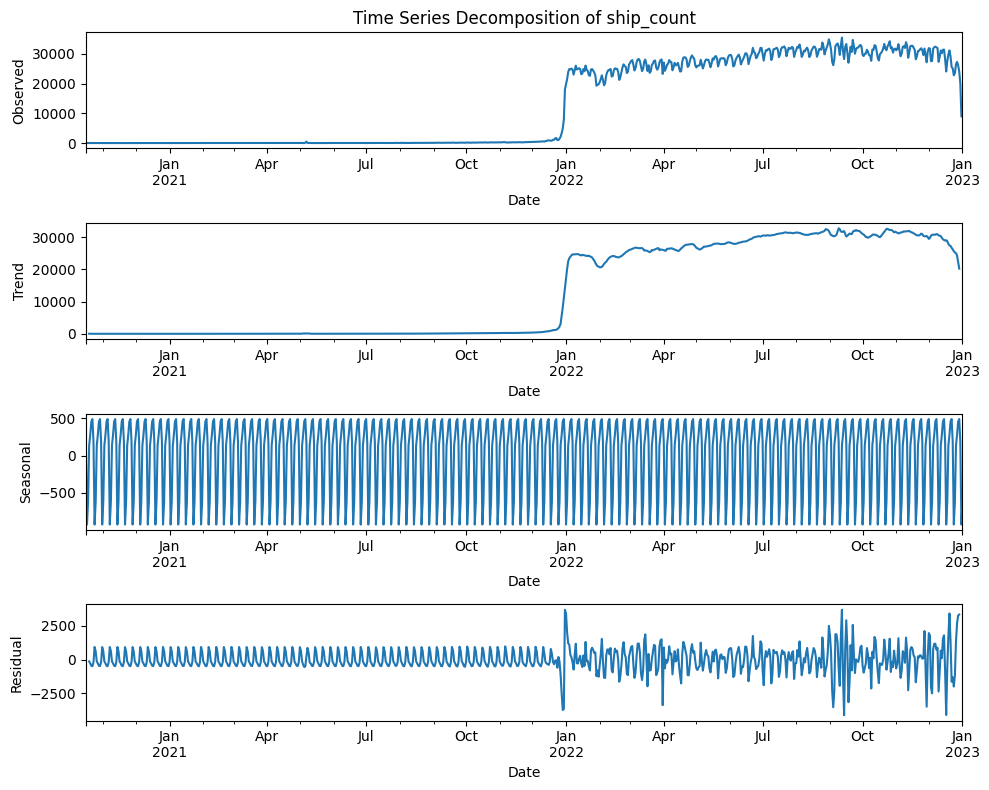

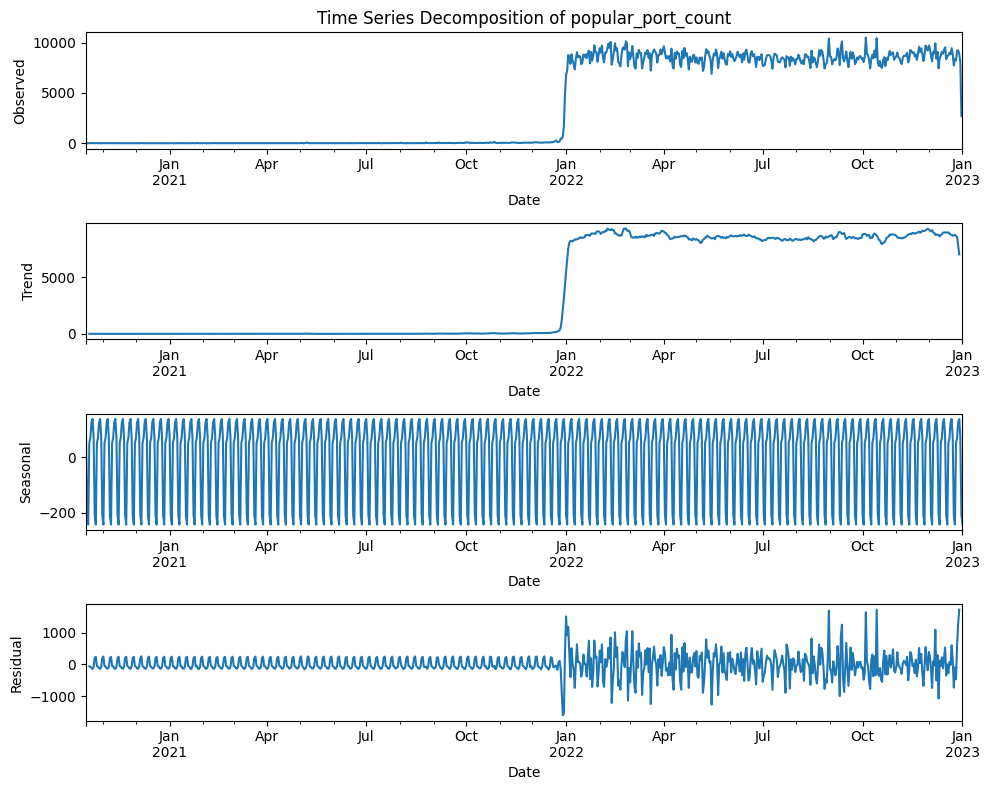

In [42]:
for column in FEATURE_COLUMNS:
    series = df[column].dropna()
    if not series.empty:  
        decomposition = sm.tsa.seasonal_decompose(series, model='additive')

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
        decomposition.observed.plot(ax=ax1)
        ax1.set_ylabel('Observed')
        ax1.set_title(f'Time Series Decomposition of {column}')

        decomposition.trend.plot(ax=ax2)
        ax2.set_ylabel('Trend')

        decomposition.seasonal.plot(ax=ax3)
        ax3.set_ylabel('Seasonal')

        decomposition.resid.plot(ax=ax4)
        ax4.set_ylabel('Residual')

        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{column}' was skipped due to insufficient data after dropping NaNs.")